In [7]:
import pandas as pd
import numpy as np
import hrs_analysis_tools
import importlib
importlib.reload(hrs_analysis_tools)

<module 'hrs_analysis_tools' from '/home/kosttek/myShit/InfiniTime/ppg_analysis/hrs_analysis_tools.py'>

## Recording raw HRS3300 data
It is possible to connect to bluetooth service and get hrs data. 

1. You have to provide your own bluetooth Pinetime device address.
2. You have to start heart rate measurment on your pinetime.
3. Disconnect device 

If you get this then it is possible that you have to turn on heart rate measurement and wait a while then start recording: 
`ValueError: min() arg is an empty sequence"`

4. When You want to stop recording you have to stop the cell

In [6]:
import time
import asyncio
from bleak import BleakClient
import time
import struct
import json

address = "CC:7B:FA:D0:A6:DB"
MODEL_NBR_UUID = "2A39"

metadata = {
    "infinitime_version" : 1.14,
    "led_current_mA": 40,
    "delay_ms": 50,
    "description": "steady hand"
}

async def main(address):
    async with BleakClient(address) as client:
        while True:
            raw_data = await client.read_gatt_char(MODEL_NBR_UUID)            
            int_array = np.array(list(struct.unpack('<64H', raw_data)))
            yield int_array
            await asyncio.sleep(1)

timestamp = str(int(time.time()))
data_file = open(f"data/{timestamp}_data.csv", "w")
time_file = open(f"data/{timestamp}_time.csv", "w")

with open(f"data/{timestamp}_metadatadata.json", "w") as metadata_file:
    metadata_file.write(json.dumps(metadata, indent=4))


def foo(agg,a1,a2):
    time_file.write(str(time.time()) + "\n")
    data_file.write(",".join([str(x)for x in a2]) + "\n")
    time_file.flush()
    data_file.flush()
    print(a2)


try:
    gen = main(address)
    await hrs_analysis_tools.process(gen, iteration_listener_func=foo )
finally:
    data_file.close()
    time_file.close()
    

[3695 3665 3650 3653 3672 3660 3647 3650 3656 3659 3646 3628 3631 3639
 3640 3650 3658 3665 3671 3679 3681 3651 3640 3647 3652 3656 3664 3674
 3679 3686 3695 3680 3657 3663 3661 3660 3653 3648 3647 3643 3620 3619
 3625 3628 3635 3642 3650 3653 3658 3639 3625 3628 3632 3632 3641 3641
 3644 3645 3637 3611 3641 3644 3645 3637]
[3646 3628 3631 3639 3640 3650 3658 3665 3671 3679 3681 3651 3640 3647
 3652 3656 3664 3674 3679 3686 3695 3680 3657 3663 3661 3660 3653 3648
 3647 3643 3620 3619 3625 3628 3635 3642 3650 3653 3658 3639 3625 3628
 3632 3632 3641 3641 3644 3645 3637 3611 3610 3621 3626 3631 3642 3657
 3659 3639 3631 3633 3637 3659 3639 3631]
[3646 3628 3631 3639 3640 3650 3658 3665 3671 3679 3681 3651 3640 3647
 3652 3656 3664 3674 3679 3686 3695 3680 3657 3663 3661 3660 3653 3648
 3647 3643 3620 3619 3625 3628 3635 3642 3650 3653 3658 3639 3625 3628
 3632 3632 3641 3641 3644 3645 3637 3611 3610 3621 3626 3631 3642 3657
 3659 3639 3631 3633 3637 3659 3639 3631]
[3646 3628 3631 3639 3

CancelledError: 

## Recording raw data and visualize it with simple ppg algorithm in notebook



Button(description='mark', style=ButtonStyle())

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

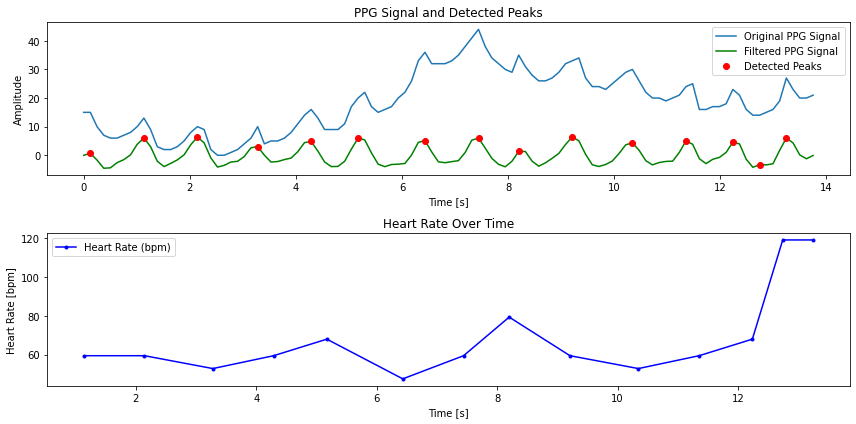

Average Heart Rate: 68.78 bpm


CancelledError: 

In [24]:
%matplotlib inline
import time
import pylab as pl
from IPython import display
import asyncio
from bleak import BleakClient
import time
import struct
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

import time
import asyncio
from bleak import BleakClient
import time
import struct
import json
import ipywidgets as widgets 
  


address = "CC:7B:FA:D0:A6:DB"
MODEL_NBR_UUID = "2A39"

metadata = {
    "infinitime_version" : 1.14,
    "led_current_mA": 12,
    "delay_ms": 50, # wait time between conversion cycle
    "description": "steady hand led12"
}

async def main(address):
    async with BleakClient(address) as client:
        while True:
            raw_data = await client.read_gatt_char(MODEL_NBR_UUID)            
            int_array = np.array(list(struct.unpack('<64H', raw_data)))
            yield int_array
            await asyncio.sleep(1)

timestamp = str(int(time.time()))
data_file = open(f"data/{timestamp}_data.csv", "w")
time_file = open(f"data/{timestamp}_time.csv", "w")

with open(f"data/{timestamp}_metadatadata.json", "w") as metadata_file:
    metadata_file.write(json.dumps(metadata, indent=4))

def click(arg):
    with open(f"data/{timestamp}_mark.csv", "a") as mark_file:
        mark_file.write(str(time.time()) + "\n")
        mark_file.flush
        print("xx")
        
# creating button 
button = widgets.Button(description = 'mark') 
button.on_click(click)



def foo(agg,a1,a2):
    time_file.write(str(time.time()) + "\n")
    data_file.write(",".join([str(x)for x in a2]) + "\n")
    time_file.flush()
    data_file.flush()
    
    aggregator2 = agg[max(-120, -len(agg)):-10]
    ppg_signal = aggregator2-min(aggregator2)
    
    time_space = np.linspace(0, len(aggregator2)/8, len(aggregator2)) 

    # Step 1: Apply a bandpass filter to remove noise
    def bandpass_filter(signal, lowcut, highcut, fs, order=5):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        filtered_signal = filtfilt(b, a, signal)
        return filtered_signal

    fs = 10  # Sampling frequency (100 Hz)
    lowcut = 0.5  # Lower bound of heart rate (30 bpm)
    highcut = 3.0  # Upper bound of heart rate (180 bpm)
    filtered_ppg = bandpass_filter(ppg_signal, lowcut, highcut, fs)

    # Step 2: Detect peaks in the filtered PPG signal
    peaks, _ = find_peaks(filtered_ppg, distance=fs/2.5)  # Roughly expect a peak every ~0.4s (150 bpm max)

    # Step 3: Calculate heart rate from peaks
    peak_times = time_space[peaks]  # Time of each detected peak
    rr_intervals = np.diff(peak_times)  # Time between consecutive peaks (in seconds)
    heart_rate = 60 / rr_intervals  # Convert RR intervals to heart rate in bpm

    
    # Step 4: Visualize the results
    display.clear_output(wait=True)
    display.display(button)
    display.display(pl.gcf())
    pl.figure(figsize=(12, 6))

    pl.subplot(2, 1, 1)
    pl.plot(time_space, ppg_signal, label='Original PPG Signal')
    pl.plot(time_space, filtered_ppg, label='Filtered PPG Signal', color='green')
    pl.plot(time_space[peaks], filtered_ppg[peaks], 'ro', label='Detected Peaks')
    pl.title('PPG Signal and Detected Peaks')
    pl.xlabel('Time [s]')
    pl.ylabel('Amplitude')
    pl.legend()

    pl.subplot(2, 1, 2)
    pl.plot(peak_times[1:], heart_rate, 'b.-', label='Heart Rate (bpm)')
    pl.title('Heart Rate Over Time')
    pl.xlabel('Time [s]')
    pl.ylabel('Heart Rate [bpm]')
    pl.legend()

    pl.tight_layout()
    pl.show()

    
    print("Average Heart Rate: {:.2f} bpm".format(np.mean(heart_rate)))



try:
    gen = main(address)
    await hrs_analysis_tools.process(gen, iteration_listener_func=foo )
finally:
    pass
    #data_file.close()
    #time_file.close()
